In [31]:
import pandas as pd

df_income = pd.read_csv('../data/low_income_classification_by_year.csv')

df_income_subset = df_income[['zip_code', 'msa_name', 'year', 'income']]

df_college = pd.read_csv('../data/college_educated_classification_gentrified_overtime.csv')

df_college_subset = df_college[['zip_code', 'msa_name', 'year', 'per_college_educated']]

df_rent_2011 = pd.read_csv('../data/rent_2011.csv')

df_rent_2011 = df_rent_2011[['zip_code', 'msa_name', 'year', 'median_contract_rent']]

df_rent_later = pd.read_csv('../data/rent_2012_2023.csv')

df_rent_later = df_rent_later[['zip_code', 'msa_name', 'year', 'median_contract_rent']]

df_rent = pd.concat([df_rent_later, df_rent_2011], ignore_index=True)

df_rent = df_rent.dropna(axis=1, how='any')

df = pd.merge(df_income_subset, df_college_subset, on=['zip_code', 'msa_name', 'year'], how='left')

df = pd.merge(df, df_rent, on=['zip_code', 'msa_name', 'year'], how='left')

df['zip_code'] = df['zip_code'].astype(str).str.zfill(5)

df = df.dropna()

df

,zip_code,msa_name,year,income,per_college_educated,median_contract_rent
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.100000,2869.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.000000,5897.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.700000,2055.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.700000,272.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.200000,5257.0
...,...,...,...,...,...,...
199409,99705,"Fairbanks, AK MSA",2023,96966.0,23.235542,1702.0
199410,99709,"Fairbanks, AK MSA",2023,82991.0,39.784946,4452.0
199411,99712,"Fairbanks, AK MSA",2023,103494.0,34.573561,683.0
199412,99714,"Fairbanks, AK MSA",2023,71042.0,24.044734,38.0


In [32]:
df_start = df[df['year'] == 2012].copy()
df_end = df[df['year'] == 2022].copy()

df_start = df_start.rename(columns={
    'income': 'income_2012',
    'per_college_educated': 'college_2012',
    'median_contract_rent': 'rent_2012'
})

df_end = df_end.rename(columns={
    'income': 'income_2022',
    'per_college_educated': 'college_2022',
    'median_contract_rent': 'rent_2022'
})

df_merged = pd.merge(df_start, df_end, on=['zip_code', 'msa_name'], how='inner')

df_merged

,zip_code,msa_name,year_x,income_2012,college_2012,rent_2012,year_y,income_2022,college_2022,rent_2022
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.1,2869.0,2022,20260.0,20.575270,3147.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.0,5897.0,2022,17703.0,22.823391,8366.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.7,2055.0,2022,22796.0,21.915303,2389.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.7,272.0,2022,15658.0,28.327645,202.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.2,5257.0,2022,20283.0,24.169736,5551.0
...,...,...,...,...,...,...,...,...,...,...
16353,99705,"Fairbanks, AK MSA",2012,80606.0,18.1,1955.0,2022,88788.0,23.022390,1742.0
16354,99709,"Fairbanks, AK MSA",2012,72900.0,39.6,4365.0,2022,80467.0,40.215682,4455.0
16355,99712,"Fairbanks, AK MSA",2012,88716.0,34.3,818.0,2022,105787.0,31.573135,750.0
16356,99714,"Fairbanks, AK MSA",2012,69219.0,34.7,119.0,2022,66250.0,29.319955,45.0


In [33]:
df_merged['income_change'] = df_merged['income_2022'] - df_merged['income_2012']
df_merged['rent_change'] = df_merged['rent_2022'] - df_merged['rent_2012']
df_merged['college_change'] = df_merged['college_2022'] - df_merged['college_2012']

msa_medians = df_merged.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()
msa_medians = msa_medians.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

df_final = pd.merge(df_merged, msa_medians, on='msa_name', how='left')

In [34]:
df_final['gentrified'] = (
    (df_final['income_change'] > df_final['msa_income_median']) &
    (df_final['rent_change'] > df_final['msa_rent_median']) &
    (df_final['college_change'] > df_final['msa_college_median'])
).astype(int)

df_final

,zip_code,msa_name,year_x,income_2012,college_2012,rent_2012,year_y,income_2022,college_2022,rent_2022,income_change,rent_change,college_change,msa_income_median,msa_rent_median,msa_college_median,gentrified
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.1,2869.0,2022,20260.0,20.575270,3147.0,5154.0,278.0,0.475270,5673.0,314.0,3.181886,0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.0,5897.0,2022,17703.0,22.823391,8366.0,2624.0,2469.0,1.823391,5673.0,314.0,3.181886,0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.7,2055.0,2022,22796.0,21.915303,2389.0,5873.0,334.0,7.215303,5673.0,314.0,3.181886,1
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.7,272.0,2022,15658.0,28.327645,202.0,4007.0,-70.0,13.627645,5673.0,314.0,3.181886,0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.2,5257.0,2022,20283.0,24.169736,5551.0,5548.0,294.0,6.969736,5673.0,314.0,3.181886,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16353,99705,"Fairbanks, AK MSA",2012,80606.0,18.1,1955.0,2022,88788.0,23.022390,1742.0,8182.0,-213.0,4.922390,8789.5,-12.0,-1.967382,0
16354,99709,"Fairbanks, AK MSA",2012,72900.0,39.6,4365.0,2022,80467.0,40.215682,4455.0,7567.0,90.0,0.615682,8789.5,-12.0,-1.967382,0
16355,99712,"Fairbanks, AK MSA",2012,88716.0,34.3,818.0,2022,105787.0,31.573135,750.0,17071.0,-68.0,-2.726865,8789.5,-12.0,-1.967382,0
16356,99714,"Fairbanks, AK MSA",2012,69219.0,34.7,119.0,2022,66250.0,29.319955,45.0,-2969.0,-74.0,-5.380045,8789.5,-12.0,-1.967382,0


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

test_df = df_final[df_final['msa_name'] == "Boston-Cambridge-Quincy, MA-NH MSA"]

X = test_df[['income_2012', 'rent_2012', 'college_2012']]
y = test_df['gentrified']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
model = LogisticRegression(penalty='l2', C=0.1,class_weight='balanced',max_iter=1000)

pipeline = make_pipeline(scaler, model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])

In [36]:
df_start_t = df[df['year'] == 2013].copy()
df_end_t = df[df['year'] == 2023].copy()

df_start_t = df_start_t.rename(columns={
    'income': 'income_2013',
    'per_college_educated': 'college_2013',
    'median_contract_rent': 'rent_2013'
})

df_end_t = df_end_t.rename(columns={
    'income': 'income_2023',
    'per_college_educated': 'college_2023',
    'median_contract_rent': 'rent_2023'
})

df_merged_t = pd.merge(df_start_t, df_end_t, on=['zip_code', 'msa_name'], how='inner')

df_merged_t

,zip_code,msa_name,year_x,income_2013,college_2013,rent_2013,year_y,income_2023,college_2023,rent_2023
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15663.0,20.1,2880.0,2023,21702.0,22.547348,3103.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15485.0,20.9,6168.0,2023,19243.0,23.917408,8389.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,16707.0,13.8,2202.0,2023,23732.0,23.986928,2423.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,11596.0,15.6,292.0,2023,18295.0,30.172414,182.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15600.0,18.0,5469.0,2023,20673.0,23.656758,5004.0
...,...,...,...,...,...,...,...,...,...,...
16313,99705,"Fairbanks, AK MSA",2013,76156.0,18.4,2192.0,2023,96966.0,23.235542,1702.0
16314,99709,"Fairbanks, AK MSA",2013,71287.0,39.5,4715.0,2023,82991.0,39.784946,4452.0
16315,99712,"Fairbanks, AK MSA",2013,85085.0,35.3,737.0,2023,103494.0,34.573561,683.0
16316,99714,"Fairbanks, AK MSA",2013,76250.0,35.3,89.0,2023,71042.0,24.044734,38.0


In [37]:
df_merged_t['income_change'] = df_merged_t['income_2023'] - df_merged_t['income_2013']
df_merged_t['rent_change'] = df_merged_t['rent_2023'] - df_merged_t['rent_2013']
df_merged_t['college_change'] = df_merged_t['college_2023'] - df_merged_t['college_2013']

msa_medians_t = df_merged_t.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()
msa_medians_t = msa_medians_t.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

df_test_t = pd.merge(df_merged_t, msa_medians_t, on='msa_name', how='left')

In [38]:
df_test_t['gentrified'] = (
    (df_test_t['income_change'] > df_test_t['msa_income_median']) &
    (df_test_t['rent_change'] > df_test_t['msa_rent_median']) &
    (df_test_t['college_change'] > df_test_t['msa_college_median'])
).astype(int)

df_test_t

,zip_code,msa_name,year_x,income_2013,college_2013,rent_2013,year_y,income_2023,college_2023,rent_2023,income_change,rent_change,college_change,msa_income_median,msa_rent_median,msa_college_median,gentrified
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15663.0,20.1,2880.0,2023,21702.0,22.547348,3103.0,6039.0,223.0,2.447348,6286.0,222.0,3.828907,0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15485.0,20.9,6168.0,2023,19243.0,23.917408,8389.0,3758.0,2221.0,3.017408,6286.0,222.0,3.828907,0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,16707.0,13.8,2202.0,2023,23732.0,23.986928,2423.0,7025.0,221.0,10.186928,6286.0,222.0,3.828907,0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,11596.0,15.6,292.0,2023,18295.0,30.172414,182.0,6699.0,-110.0,14.572414,6286.0,222.0,3.828907,0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15600.0,18.0,5469.0,2023,20673.0,23.656758,5004.0,5073.0,-465.0,5.656758,6286.0,222.0,3.828907,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,99705,"Fairbanks, AK MSA",2013,76156.0,18.4,2192.0,2023,96966.0,23.235542,1702.0,20810.0,-490.0,4.835542,13570.0,-52.5,-4.061560,0
16314,99709,"Fairbanks, AK MSA",2013,71287.0,39.5,4715.0,2023,82991.0,39.784946,4452.0,11704.0,-263.0,0.284946,13570.0,-52.5,-4.061560,0
16315,99712,"Fairbanks, AK MSA",2013,85085.0,35.3,737.0,2023,103494.0,34.573561,683.0,18409.0,-54.0,-0.726439,13570.0,-52.5,-4.061560,0
16316,99714,"Fairbanks, AK MSA",2013,76250.0,35.3,89.0,2023,71042.0,24.044734,38.0,-5208.0,-51.0,-11.255266,13570.0,-52.5,-4.061560,0


In [39]:
test_df_t = df_test_t[df_test_t['msa_name'] == "Boston-Cambridge-Quincy, MA-NH MSA"]

# Step 2: prepare X and y
X_eval = test_df_t[['income_2013', 'rent_2013', 'college_2013']]
X_eval.columns = ['income_2012', 'rent_2012', 'college_2012']
y_eval = test_df_t['gentrified']  # your binary target column

# If you scaled your training data, scale X_eval with the same scaler
X_eval_scaled = scaler.transform(X_eval)

# Step 3: get predicted probabilities
y_probs = model.predict_proba(X_eval_scaled)[:, 1]

# Step 4: calculate log-likelihood (log loss), or other metrics
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score

ll = -log_loss(y_eval, y_probs, normalize=False)  # negative log loss = log likelihood approx
auc = roc_auc_score(y_eval, y_probs)
acc = accuracy_score(y_eval, model.predict(X_eval_scaled))

print(f'Log Likelihood (approx): {ll}')
print(f'AUC: {auc:.3f}')
print(f'Accuracy: {acc:.3f}')

Log Likelihood (approx): -177.63408363061654
AUC: 0.659
Accuracy: 0.648


In [40]:
wide_table = df.pivot(index=['zip_code', 'msa_name'], columns='year')

wide_table.columns = [f'{var}_{year}' for var, year in wide_table.columns]

wide_table = wide_table.dropna()

df_test = wide_table.loc[wide_table.index.get_level_values('msa_name') == "Boston-Cambridge-Quincy, MA-NH MSA"]

years = [2012, 2023]
income_change = df_test['income_2023'] - df_test['income_2012']
annual_growth_income = income_change / (2023 - 2012)

df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)

rent_change = df_test['median_contract_rent_2023'] - df_test['median_contract_rent_2012']
annual_growth_rent = rent_change / (2023 - 2012)

df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)

college_change = df_test['per_college_educated_2023'] - df_test['per_college_educated_2012']
annual_growth_college = college_change / (2023 - 2012)

df_test['college_2030'] = df_test['per_college_educated_2023'] + annual_growth_college * (2030 - 2023)

df_test

/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3196678672.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3196678672.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31966

,,income_2012,income_2013,income_2014,income_2015,income_2016,income_2017,income_2018,income_2019,income_2020,income_2021,...,median_contract_rent_2017,median_contract_rent_2018,median_contract_rent_2019,median_contract_rent_2020,median_contract_rent_2021,median_contract_rent_2022,median_contract_rent_2023,income_2030,rent_2030,college_2030
zip_code,msa_name,,,,,,,,,,,,,,,,,,,,,
01431,"Boston-Cambridge-Quincy, MA-NH MSA",75435.0,82778.0,83917.0,82019.0,89934.0,95833.0,101357.0,97958.0,97269.0,95536.0,...,135.0,97.0,90.0,84.0,89.0,56.0,73.0,132873.000000,89.545455,47.839453
01432,"Boston-Cambridge-Quincy, MA-NH MSA",58519.0,57543.0,66630.0,72048.0,77462.0,79750.0,91156.0,94375.0,99195.0,97097.0,...,1306.0,1322.0,1251.0,1192.0,1144.0,1124.0,1039.0,134811.181818,897.090909,39.630001
01434,"Boston-Cambridge-Quincy, MA-NH MSA",101000.0,77396.0,97222.0,77014.0,54318.0,50547.0,66477.0,92426.0,96500.0,140391.0,...,88.0,72.0,56.0,35.0,0.0,45.0,98.0,115156.181818,155.909091,26.662815
01450,"Boston-Cambridge-Quincy, MA-NH MSA",117037.0,117127.0,116686.0,116642.0,117500.0,123918.0,126883.0,129085.0,142500.0,169643.0,...,508.0,538.0,580.0,433.0,467.0,445.0,381.0,235375.545455,291.272727,55.630822
01460,"Boston-Cambridge-Quincy, MA-NH MSA",107518.0,105455.0,111652.0,111680.0,108704.0,119177.0,120638.0,123413.0,125275.0,140511.0,...,544.0,525.0,427.0,391.0,461.0,483.0,563.0,170897.636364,640.000000,57.582964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03874,"Boston-Cambridge-Quincy, MA-NH MSA",56547.0,54167.0,51871.0,53587.0,56184.0,62005.0,67261.0,73046.0,76315.0,79072.0,...,1395.0,1322.0,1248.0,1179.0,1160.0,998.0,1124.0,106379.181818,903.818182,33.415532
03878,"Boston-Cambridge-Quincy, MA-NH MSA",53481.0,53241.0,53105.0,54868.0,60976.0,62723.0,64829.0,66737.0,67293.0,68909.0,...,2182.0,2119.0,2338.0,2360.0,2091.0,1844.0,2020.0,96370.090909,2013.636364,29.417498
03884,"Boston-Cambridge-Quincy, MA-NH MSA",85682.0,93629.0,97333.0,95707.0,89333.0,102688.0,90900.0,94321.0,110972.0,120453.0,...,145.0,142.0,124.0,104.0,87.0,97.0,95.0,145247.272727,94.363636,40.419082


In [41]:
X_future = df_test[['income_2030', 'rent_2030', 'college_2030']].dropna().copy()
X_future.columns = ['income_2012', 'rent_2012', 'college_2012']

X_future_scaled = scaler.transform(X_future)

gentrification_probs_2035 = model.predict_proba(X_future_scaled)[:, 1]

df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035

df_test.to_csv('../data/boston_gentrification_stats.csv')

df_test

/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/4022340077.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035


,,income_2012,income_2013,income_2014,income_2015,income_2016,income_2017,income_2018,income_2019,income_2020,income_2021,...,median_contract_rent_2018,median_contract_rent_2019,median_contract_rent_2020,median_contract_rent_2021,median_contract_rent_2022,median_contract_rent_2023,income_2030,rent_2030,college_2030,gentrification_prob_2035
zip_code,msa_name,,,,,,,,,,,,,,,,,,,,,
01431,"Boston-Cambridge-Quincy, MA-NH MSA",75435.0,82778.0,83917.0,82019.0,89934.0,95833.0,101357.0,97958.0,97269.0,95536.0,...,97.0,90.0,84.0,89.0,56.0,73.0,132873.000000,89.545455,47.839453,0.489828
01432,"Boston-Cambridge-Quincy, MA-NH MSA",58519.0,57543.0,66630.0,72048.0,77462.0,79750.0,91156.0,94375.0,99195.0,97097.0,...,1322.0,1251.0,1192.0,1144.0,1124.0,1039.0,134811.181818,897.090909,39.630001,0.498055
01434,"Boston-Cambridge-Quincy, MA-NH MSA",101000.0,77396.0,97222.0,77014.0,54318.0,50547.0,66477.0,92426.0,96500.0,140391.0,...,72.0,56.0,35.0,0.0,45.0,98.0,115156.181818,155.909091,26.662815,0.385120
01450,"Boston-Cambridge-Quincy, MA-NH MSA",117037.0,117127.0,116686.0,116642.0,117500.0,123918.0,126883.0,129085.0,142500.0,169643.0,...,538.0,580.0,433.0,467.0,445.0,381.0,235375.545455,291.272727,55.630822,0.721567
01460,"Boston-Cambridge-Quincy, MA-NH MSA",107518.0,105455.0,111652.0,111680.0,108704.0,119177.0,120638.0,123413.0,125275.0,140511.0,...,525.0,427.0,391.0,461.0,483.0,563.0,170897.636364,640.000000,57.582964,0.621921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03874,"Boston-Cambridge-Quincy, MA-NH MSA",56547.0,54167.0,51871.0,53587.0,56184.0,62005.0,67261.0,73046.0,76315.0,79072.0,...,1322.0,1248.0,1179.0,1160.0,998.0,1124.0,106379.181818,903.818182,33.415532,0.418553
03878,"Boston-Cambridge-Quincy, MA-NH MSA",53481.0,53241.0,53105.0,54868.0,60976.0,62723.0,64829.0,66737.0,67293.0,68909.0,...,2119.0,2338.0,2360.0,2091.0,1844.0,2020.0,96370.090909,2013.636364,29.417498,0.428195
03884,"Boston-Cambridge-Quincy, MA-NH MSA",85682.0,93629.0,97333.0,95707.0,89333.0,102688.0,90900.0,94321.0,110972.0,120453.0,...,142.0,124.0,104.0,87.0,97.0,95.0,145247.272727,94.363636,40.419082,0.490367


In [42]:
unique_msa = df['msa_name'].unique()

combined_results = []

for msa in unique_msa:
    test_df = df_final[df_final['msa_name'] == msa]

    X = test_df[['income_2012', 'rent_2012', 'college_2012']]
    y = test_df['gentrified']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    scaler = StandardScaler()
    model = LogisticRegression(penalty='l2', C=0.1,class_weight='balanced',max_iter=1000)

    unique_classes = y_train.unique()
    if len(unique_classes) < 2:
        print(f"Skipping {msa} because y_train has only one class: {unique_classes}")
        continue 

    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)

    df_test = wide_table.loc[wide_table.index.get_level_values('msa_name') == msa]

    years = [2012, 2023]
    income_change = df_test['income_2023'] - df_test['income_2012']
    annual_growth_income = income_change / (2023 - 2012)

    df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)

    rent_change = df_test['median_contract_rent_2023'] - df_test['median_contract_rent_2012']
    annual_growth_rent = rent_change / (2023 - 2012)

    df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)

    college_change = df_test['per_college_educated_2023'] - df_test['per_college_educated_2012']
    annual_growth_college = college_change / (2023 - 2012)

    df_test['college_2030'] = df_test['per_college_educated_2023'] + annual_growth_college * (2030 - 2023)

    X_future = df_test[['income_2030', 'rent_2030', 'college_2030']].dropna().copy()
    X_future.columns = ['income_2012', 'rent_2012', 'college_2012']

    X_future_scaled = scaler.transform(X_future)

    gentrification_probs_2035 = model.predict_proba(X_future_scaled)[:, 1]

    df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035

    combined_results.append(df_test)

df_combined = pd.concat(combined_results)

df_combined = df_combined.reset_index()

df_combined.to_csv('../data/all_gentrification_prediction.csv')

/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping San German-Cabo Rojo, PR MSA because y_train has only one class: [0]
Skipping Yauco, PR MSA because y_train has only one class: [0]
Skipping Mayaguez, PR MSA because y_train has only one class: [0]
Skipping Guayama, PR MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: 

Skipping Lebanon, PA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping Burlington, NC MSA because y_train has only one class: [0]
Skipping Goldsboro, NC MSA because y_train has only one class: [0]
Skipping Rocky Mount, NC MSA because y_train has only one class: [0]
Skipping Rome, GA MSA because y_train has only one class: [0]
Skipping Gainesville, GA MSA because y_train has only one class: [0]
Skipping Warner Robins, GA MSA because y_train has only one class: [0]
Skipping Hinesville-Fort Stewart, GA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping Palm Coast, FL MSA because y_train has only one class: [0]
Skipping Ocala, FL MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping Gadsden, AL MSA because y_train has only one class: [0]
Skipping Auburn-Opelika, AL MSA because y_train has only one class: [0]
Skipping Jackson, TN MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping Lima, OH MSA because y_train has only one class: [0]
Skipping Elkhart-Goshen, IN MSA because y_train has only one class: [0]
Skipping South Bend-Mishawaka, IN-MI MSA because y_train has only one class: [0]
Skipping Muncie, IN MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping Oshkosh-Neenah, WI MSA because y_train has only one class: [0]
Skipping Missoula, MT MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping Lawrence, KS MSA because y_train has only one class: [0]
Skipping Lafayette, LA MSA because y_train has only one class: [0]
Skipping Monroe, LA MSA because y_train has only one class: [0]
Skipping Pine Bluff, AR MSA because y_train has only one class: [0]
Skipping Texarkana, TX-Texarkana, AR MSA because y_train has only one class: [0]
Skipping Lawton, OK MSA because y_train has only one class: [0]
Skipping Sherman-Denison, TX MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping San Angelo, TX MSA because y_train has only one class: [0]
Skipping Laredo, TX MSA because y_train has only one class: [0]
Skipping Midland, TX MSA because y_train has only one class: [0]
Skipping Boulder, CO MSA because y_train has only one class: [0]
Skipping Cheyenne, WY MSA because y_train has only one class: [0]
Skipping Lewiston, ID-WA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping Coeur d'Alene, ID MSA because y_train has only one class: [0]
Skipping Santa Fe, NM MSA because y_train has only one class: [0]
Skipping Carson City, NV MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/31238

Skipping Madera, CA MSA because y_train has only one class: [0]
Skipping Napa, CA MSA because y_train has only one class: [0]
Skipping Bellingham, WA MSA because y_train has only one class: [0]
Skipping Mount Vernon-Anacortes, WA MSA because y_train has only one class: [0]
Skipping Olympia, WA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_12101/3123897537.py:35: 

Skipping Kennewick-Richland-Pasco, WA MSA because y_train has only one class: [0]
Skipping Fairbanks, AK MSA because y_train has only one class: [0]


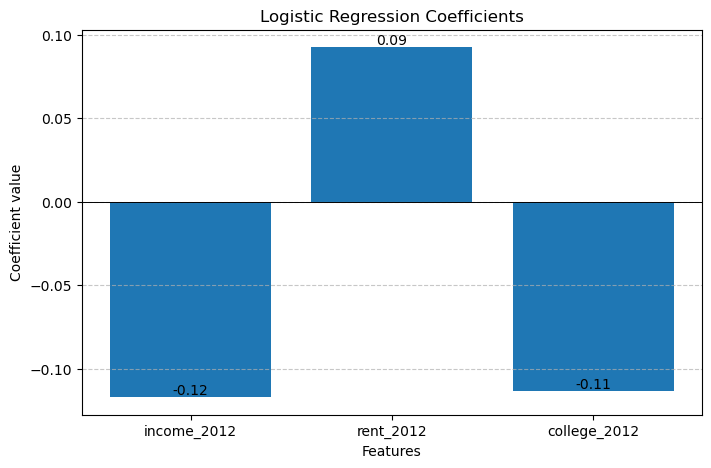

In [43]:
import matplotlib.pyplot as plt
import numpy as np

features = ['income_2012', 'rent_2012', 'college_2012']
coef = pipeline.named_steps['logisticregression'].coef_[0]

plt.figure(figsize=(8,5))
bars = plt.bar(features, coef)
plt.axhline(0, color='black', linewidth=0.7)
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient value')
plt.xlabel('Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

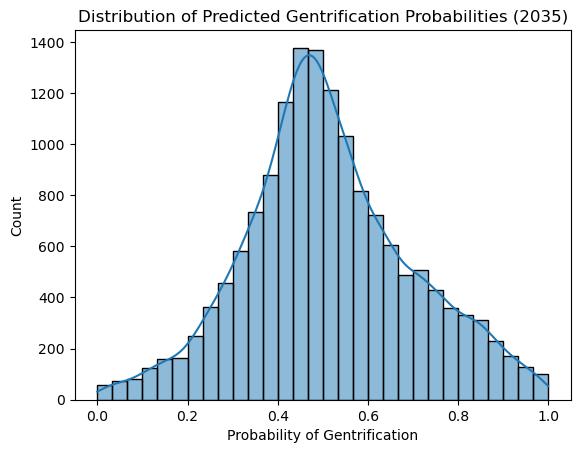

In [44]:
import seaborn as sns

sns.histplot(df_combined['gentrification_prob_2035'], bins=30, kde=True)
plt.title('Distribution of Predicted Gentrification Probabilities (2035)')
plt.xlabel('Probability of Gentrification')
plt.ylabel('Count')
plt.show()

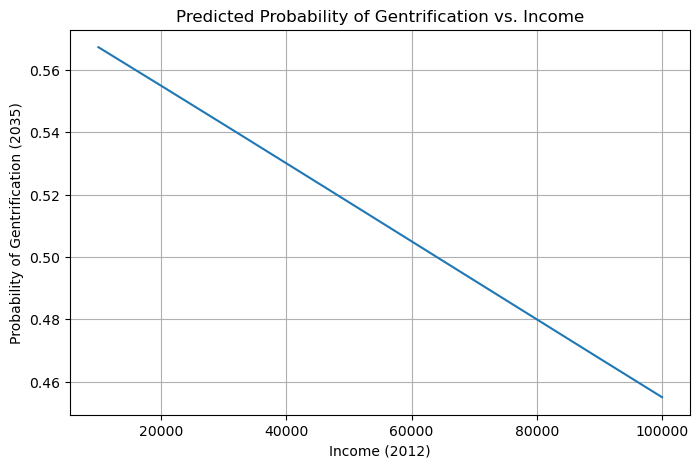

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Create a range of income values
income_range = np.linspace(10000, 100000, 500)

# Fix rent and college values at average levels
avg_rent = X_train['rent_2012'].mean()
avg_college = X_train['college_2012'].mean()

# Create input DataFrame
X_plot = pd.DataFrame({
    'income_2012': income_range,
    'rent_2012': avg_rent,
    'college_2012': avg_college
})

# Predict probabilities using the pipeline
probs = pipeline.predict_proba(X_plot)[:, 1]

# Plot
plt.figure(figsize=(8,5))
plt.plot(income_range, probs)
plt.title('Predicted Probability of Gentrification vs. Income')
plt.xlabel('Income (2012)')
plt.ylabel('Probability of Gentrification (2035)')
plt.grid(True)
plt.show()